This is a basic sentiment analysis of a set of twitter feed using recurrent neural networks. The output variable is a binary positive or negative (1 or 0) value. The recurrent neural network is done using an LSTM cell with cross entropy at the output node

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pylab import *
import os
import json, tensorflow as tf

########################################################
# Loading data
npzfile = np.load("train_and_val.npz")
train_x = npzfile["train_x"]
train_y = npzfile["train_y"]
train_mask = npzfile["train_mask"]
val_x = npzfile["val_x"]
val_y = npzfile["val_y"]
val_mask = npzfile["val_mask"]
with open("vocab.json") as vocab_file:
    vocab = json.load(vocab_file)
with open("reverse_vocab.json") as vocab_file1:
    reversevocab = json.load(vocab_file1)

0
validation_accuracy 0.484
500
validation_accuracy 0.733
1000
validation_accuracy 0.726
1500
validation_accuracy 0.755
2000
validation_accuracy 0.683
2500
validation_accuracy 0.736
3000
validation_accuracy 0.775
3500
validation_accuracy 0.791
4000
validation_accuracy 0.748
4500
validation_accuracy 0.778
5000
validation_accuracy 0.763
5500
validation_accuracy 0.784
6000
validation_accuracy 0.745
6500
validation_accuracy 0.786
7000
validation_accuracy 0.767
7500
validation_accuracy 0.779
8000
validation_accuracy 0.766
8500
validation_accuracy 0.772
9000
validation_accuracy 0.79
9500
validation_accuracy 0.76
10000
validation_accuracy 0.746
10500
validation_accuracy 0.783
11000
validation_accuracy 0.776
11500
validation_accuracy 0.769
12000
validation_accuracy 0.76
12500
validation_accuracy 0.738
13000
validation_accuracy 0.758
13500
validation_accuracy 0.764
14000
validation_accuracy 0.758
14500
validation_accuracy 0.759


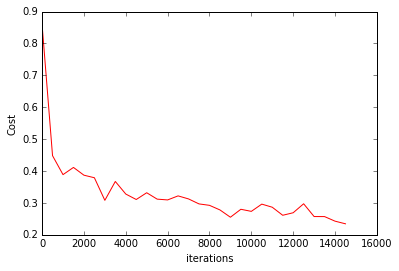

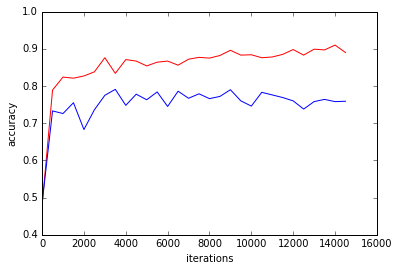

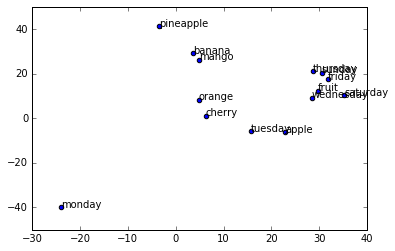

In [1]:

##############################################################
# Placeholders
x_ = tf.placeholder(tf.int32,[None,25])
y_ = tf.placeholder(tf.float32,[None,1])
w_embed =tf.Variable(tf.random_uniform([8745,100]))
w_final =tf.Variable(tf.random_uniform([25,1]))
w_final_0 = tf.Variable(tf.random_uniform([1,1]))
m_ =tf.placeholder(tf.int32,[None,25])
batch_size = 1000
#############################################################
#Functions to be used
def batch(train_x,train_y,overall_size):
    randomlist = np.random.randint(overall_size,size=1000)
    return train_x[randomlist],train_y[randomlist],train_mask[randomlist]

def avgcost(costval):
    avgcost1 = 0
    for i in range(len(costval.eval())):
        avgcost1 = avgcost1+costval.eval()[i]
    avgcost1 = avgcost1/len(costval.eval())
    return avgcost1	

def roundfun(y):
    if (y>0.5 ):
        return 1
    else:
        return 0
def Accuracy(y,y1):
    numaccurate=0;numerror=len(y)
    for i in range(len(y)):
        if(roundfun(y[i])==y1[i]):
            numaccurate=numaccurate+1
    return numaccurate*1.0/len(y)	


avgcostarray=[];iterarray=[];accuracyarray=[]
val_avgcostarray=[];val_accuracyarray=[]
#############################################################
#Tensorflow operations
rnn_input = tf.nn.embedding_lookup(w_embed, x_)	
cell = tf.contrib.rnn.LSTMCell(25)
output,state = tf.nn.dynamic_rnn(cell,rnn_input,dtype=float32,initial_state=cell.zero_state(1000,dtype=float32))
length = tf.cast(tf.reduce_sum(m_,reduction_indices=1), tf.int32)
batch_size = tf.shape(output)[0]
max_length = tf.shape(output)[1]
out_size = int(output.get_shape()[2])
flat = tf.reshape(output, [-1, out_size])
index = tf.range(0, batch_size) * max_length + (length - 1)
relevant = tf.gather(flat, index)
z = tf.add(tf.matmul(relevant, w_final),w_final_0)
prediction =tf.sigmoid(z)
ypred = tf.Variable(tf.zeros([1000,1]))
predictionassign = ypred.assign(prediction)
cost = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_, logits=z)
costval = tf.Variable(tf.zeros([1000,1]))
costassign = costval.assign(cost)
train_op =tf.train.RMSPropOptimizer(0.001,0.9).minimize(cost)
############################################################
#Main
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for iter1 in range(15000):
        batch_x,batch_y,batch_mask = batch(train_x,train_y,400000)
        batch_y = transpose(np.matrix(batch_y))
        batch_masklist = np.matrix(batch_mask)
        sess.run(train_op,feed_dict={x_:batch_x,m_:batch_masklist,y_:batch_y})
        if (iter1 % 500 ==0):
            p= w_embed.eval()
            print iter1
            writer = tf.summary.FileWriter("graph")
            writer.add_graph(sess.graph)
            random_x,random_y,random_mask = batch(train_x,train_y,400000)
            random_y = transpose(np.matrix(random_y))
            random_mask = np.matrix(random_mask)
            sess.run(predictionassign,feed_dict={x_:random_x,m_:random_mask})
            accuracy = Accuracy(ypred.eval(),random_y)
            accuracyarray.append(accuracy)			
            sess.run(costassign,feed_dict={x_:random_x,m_:random_mask,y_:random_y})
            avgcost1 = avgcost(costval)
            avgcostarray.append(avgcost1)
            iterarray.append(iter1)
            random_x,random_y,random_mask = batch(val_x,val_y,50000)
            random_y = transpose(np.matrix(random_y))
            random_mask = np.matrix(random_mask)
            sess.run(predictionassign,feed_dict={x_:random_x,m_:random_mask})
            val_accuracy = Accuracy(ypred.eval(),random_y)
            val_accuracyarray.append(val_accuracy)
            print "validation_accuracy",val_accuracy

    
    plt.plot(iterarray,avgcostarray,'r')
    plt.xlabel("iterations")
    plt.ylabel("Cost")
    plt.show()
        
    plt.plot(iterarray,accuracyarray,'r')
    plt.plot(iterarray,val_accuracyarray,'b')
    plt.xlabel("iterations")
    plt.ylabel("accuracy")
    plt.show()
###############################################################
#Visualizing words vectors

    with open("vocab.json", "r") as f:
        vocab = json.load(f)
    s = ["monday", "tuesday", "wednesday", "thursday", "friday",    "saturday", "sunday", "orange", "apple", "banana", "mango",
    "pineapple", "cherry", "fruit"]
    words = [(i, vocab[i]) for i in s]

    p = np.matrix(p)
    from sklearn.manifold import TSNE
    model = TSNE(n_components=2, random_state=0)
    tsne_embedding = model.fit_transform(p)
    words_vectors = tsne_embedding[np.array([item[1][0] for item in words])]
    y = words_vectors[:,0]
    z = words_vectors[:,1]
    fig, ax = plt.subplots()
    ax.scatter(z, y)
    for i, txt in enumerate(s):
        ax.annotate(txt, (z[i],y[i]))
    plt.show()


So, we see that the validation accuracy hoovers around 77 % and the training accuracy around 80 %. This indicates that
the algorithm is not learning much after a while. This can be an artifact of the dataset and with increaing number of 
data points, we might get a much better result